<a href="https://colab.research.google.com/github/yosefmentzer/msc_thesis/blob/master/msc_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The data: sources, content and processing  

- Data was gathered from two sources: betting market data from Betfair (major betting exchange) and game stats data from footystats, a provider of association football statistics.  



## "Physical" description  

- Betfair raw data is comprised of .tar files for each month. Each .tar file contais data for all matches available for the specific month (no option to filter relevant leagues or matches directly). Match-level data is delivered through JSON files, in Betfair's API format. Data was gathered from the first available month (May, 2015) to Jan, 2020 (up to the point when competitions were suspended due to the pandemic). Total: 57 months (~1GB, compressed).  
- Footystats raw data is comprised of .csv files for each competition-year. 201 raw files were consolidated  into one "footy data" file. 



## Content description  

- The main information recorded in the Betfair data set is the last traded price (market odds) on a minute-by-minute basis (both pre-live and in-play) for bets on the three underlying events: victory of home team (Home win); victory of away team (Away win); and a tie (Draw). The market is suspended when “material events” such as goals or red cards occur, but the Betfair data set does not record the event itself.
- There is a field identifying whether the row is "in-play" or not. Volume is not available. Scheduled date and time, country and team names identify the match. The competition/tournament to which the match relates is not identified.  
- The footystats data set contains game stats data for each match. The most relevant information is the timing of each goal. Corners, shots, fouls and cards are available only as aggregate information (no timing). Therefore, we cannot characterize a "game state" for each minute.
- Leagues: Argentina, Australia, Brazil (1 and 2), China, England (1 and 2), France (1 and 2), Germany (1 and 2), Israel, Italy (1 and 2), Japan, Netherlands, Portugal, Russia, Scotland, Spain (1 and 2), Turkey and USA. Cups were also initially included, but they were excluded due to the very high number of participants in the first rounds, mostly teams from lower leagues.



## Building keys to join both data sets  

- Given that there are no "match ids" or "team ids", the data sets were joined using the country, team names and the date and time of scheduled kickoff.  
- Team names are not standardized between data sets and - in many cases - even whithin data sets.  
- Team names were matched using both a string similarity algorithm and manual checks. Results were validated by the percentage of games in the footy stats database for which the corresponding record in the Betfair database was found for each team. A low percentage for a specific team indicated that there was a possible "nickname" or alternative/old name for the team, not grasped by the string similarity algorithm and specific research was performed. The final percentages are fairly homogeneous for teams within each country, reflecting the availability of matches in the Betfair data set, varying from 65% to 90%.  
-The "join" was of the "left" type, on "footy data", as the game data set is the one cointaining relevant matches exclusively and the Betfair (market) data set contains data for a much larger set of matches. Thus, for each relevant match within the game data set, the corresponding market data was searched for.  
- Total average of relevant matches with market data is about 85%. [Choi and Hui (2014)](https://github.com/yosefmentzer/msc_thesis/blob/master/JEBO_ChoiHui_2014_TheRoleofSurprise.pdf) report 70% of available matches. I contacted Betfair and they confirmed that there is missing data due to data recording issues.  
-  Timing: the market data set contains a column with "PT - Published Time" in Unix time, which was converted to a "date time" object. The game data set contains goal timings in "game minutes" (i.e. 20', 45'+2, 58', etc.). As Betfair markets go live at kickoff, the PT at which markets go "in-play" are referenced as "time = 0 minutes".   Therefore, the market data set is timed in "minutes after kickoff" and the game data set is timed in "game minutes". For example, the "game minute" 47, i.e. 2 minutes into the 2nd half, may correspond, for example, to a "clock timing" of 47 + 3 (1st half injury time) + 15 (halftime) + 1 (halftime delay) = 66 minutes after kickoff. In contrast, the "game minute" 45+2, i.e. 2 minutes into injury time in the 1st half, corresponds to a "clock timing" of 47' after kickoff.



## Sanity check  

- A "sanity check" was performed on market data in order to identify and deal with potential issues.  
- The number of in-play data records for each match, which should roughly correspond to the number of minutes from kickoff to the final whistle (typically around 115 minutes), was assessed. The high proportion of matches with more than 120 in-play records until 2018 was investigated and Betfair informed that due to operational reasons there was more than one file of data for part of the matches. The data was merged, fixing the issue.  
- Matches with few in-play records were also investigated and in most cases there is a heavy favorite (low pre-match market odds, or high pre-match risk-neutral implied percentage) scoring early in the first half. The price then "converges" to risk-neutral percentages close to 100% and liquidity vanishes until the final whistle. The low number of in-play data records in this case is thus, legitimate.  
- "Gaps" in data set records were identified. (e.g. data for minutes 0, 1, 2, 3, 5, 6 are available but there is no data for minute 4). Betfair informed that these "gaps" in the data are legitimate and reflect a lack of change in last traded prices, in case last traded prices coincide with the previous minute or in case there is no liquidity in the specific minute. It is not a "missing data" issue and the last traded prices are actually the previous minute's prices. This is due to the fact that Betfair's API registers only "new information", so the omission in the data set is actually an observation of a price that did not change. The processed database was populated accordingly.  
- As a match approaches the final whistle, the currently winning bet's implied probability approaches 100%. If prices do not "converge" by the time the market is closed, it is a sign that the market was interrupted before the match's actual end. A concrete case was discussed with Betfair's technical support and this may, occasionally, happen due to technical reasons. Therefore, matches with prices that do not converge, matches with very low number of records (less than 20), or matches whose markets close before 105 minutes of in-play activity (indicating that they went in-play late) were excluded. 
-  Matches that did not pass the sanity check are around 1.5% of total relevant matches.



## Identifying goals in the market data set  

- As the market data set does not contain game information explicitly, the market data set and the game data set need to be compared and joined, specifically for goal timings.  
- Goals typically cause a sharp change in prices, reflecting a jump in risk-neutral probabilities associated to the match's outcome. Therefore, the identification of goals in the market data set is based on both the level of change in prices and its timing vis-à-vis the goal timings in the game data set. 
- Goals that do not contribute much to define the match's result cause a less sharp change in prices. In extreme cases the goal may not move the market (for example, the fifth goal of a heavy favorite when the score is already 4-0), as implied probabilities have already converged to values close to 100% or 0% accordingly. As we do not intend to work with those goals, this is not a concern to us.  
- In order to spot the timing of goals in the market data set, we thus define a "change in prices criterion": the change in logodds associated to risk-neutral implied probabilities must be above a threshold, way above normal in-game variations and time decay. It must be a jump.  
- Timing criterion - 1st half: for 1st half goals, the timing in the market data set and in the game data set must match, allowing for a one-minute difference to accomodate roundings.  
- Timing criterion - 2nd half: for the first goal of the 2nd half, the timing in the market data set is allowed to be later than the timing in the game data set + 15min (halftime break). For example, let us say that the goal in the game data set is recorded as having happened at minute 49. Adding 15min, the reference is 64'. Allowing more minutes to accomodate 1st half injury time and a possible delay from the halftime break, let us say that we find a jump in prices at 68'. This is thus the "clock" goal timing. The effective injury time +halftime delay was found to be 68-64=4'. Let us say that the game data set registers the next goal at minute 59 (game timing). So the next jump must be at a "clock" timing of 59 + 15(halftime) + 4 = 78', allowing for a one-minute difference to accomodate roundings.  
- At this point, matches with red cards were excluded from the sample, as red cards cause sharp jumps in prices (less than goals), but their timings are not available in the game data set. Red cards may be a confounding factor for goal identification. This should not be a methodological issue as the hypothesis H0  should be robust to a sub-set of matches without red cards. Additionally, the remaining sample remains large.   
- Once the goal timing was identified, a vector from the minute immediately before the goal (t0) up to five minutes after the goal (t5) was determined. If there is another goal in this period, we keep only the minutes before the new goal, like [Choi and Hui (2014)](https://github.com/yosefmentzer/msc_thesis/blob/master/JEBO_ChoiHui_2014_TheRoleofSurprise.pdf).    


# The data (after processing, sanity check)  


Import processed data sets

In [ ]:
import pandas as pd

years = [15,16,17,18,19,20]
bf_goals_df = pd.DataFrame()

for year in years:
  url = 'https://raw.githubusercontent.com/yosefmentzer/msc_thesis/master/bf_goals_df_' + str(year) + '.csv'
  df = pd.read_csv(url, index_col=0)
  bf_goals_df = bf_goals_df.append(df, ignore_index=True)

url = 'https://raw.githubusercontent.com/yosefmentzer/msc_thesis/master/footy_data.csv'
footy_data = pd.read_csv(url)
footy_data = footy_data[footy_data['active']==1]

print('bf_goals_df shape is {}'.format(bf_goals_df.shape))
print('footy_data shape is {}'.format(footy_data.shape))

bf_goals_df shape is (332150, 61)
footy_data shape is (30555, 97)


Total number of matches per league and per country

In [ ]:
import numpy as np
df = footy_data[footy_data['active']==1].copy()
df['year'] = df['year'].astype(int)

pd.pivot_table(df, values='active', index=['country','competition'],
                    columns=['year'], aggfunc=np.sum, fill_value=0, margins=True)

year                                    15    16    17    18    19   20    All
country       competition                                                     
Argentina     primera-division         264   361   343   291   321   12   1592
Australia     a-league                   0    60   122    98   124   20    424
Brazil        serie-a                  345   340   285   275   348    0   1593
              serie-b                  334     0   271   249   352    0   1206
China         chinese-super-league     134   214   169    34   194    0    745
England       championship             277   501   501   481   537   50   2347
              premier-league           180   345   352   315   367   41   1600
France        ligue-1                  186   326   323   291   345   14   1485
              ligue-2                  178   339   339   345   353   28   1582
Germany       2-bundesliga             166   253   280   256   297   11   1263
              bundesliga               143   266   284   272   293   19   1277
Israel        israeli-premier-league     4    55    94   133   221   29    536
Italy         serie-a                  161   356   346   260   324   39   1486
              serie-b                  220   418   405   343   357   20   1763
Japan         j1-league                224   284   263   273   294    0   1338
Netherlands   eredivisie               148   291   288   271   314   19   1331
Portugal      liga-nos                 125   279   235   230   270   37   1176
Russia        russian-premier-league   121   183   195   169   234    0    902
Scotland      premiership              116   214   205   187   209   14    945
Spain         la-liga                  161   338   312   286   367   29   1493
              segunda-division         186   362   355   379   452   40   1774
Turkey        super-lig                143   250   268   240   283   18   1202
United States mls                      249   258   308   286   394    0   1495
All                                   4065  6293  6543  5964  7250  440  30555

Excluding matches with red cards (roughly 20%):

In [ ]:
import numpy as np
df = footy_data[footy_data['active']==1].copy()
df['year'] = df['year'].astype(int)
df = df[(df['home_team_red_cards'] == 0) & (df['away_team_red_cards'] == 0)]

pd.pivot_table(df, values='active', index=['country','competition'],
                    columns=['year'], aggfunc=np.sum, fill_value=0, margins=True)

year                                    15    16    17    18    19   20    All
country       competition                                                     
Argentina     primera-division         161   255   254   224   234    9   1137
Australia     a-league                   0    49    95    78   105   17    344
Brazil        serie-a                  267   274   236   219   272    0   1268
              serie-b                  257     0   219   191   277    0    944
China         chinese-super-league     114   187   141    29   156    0    627
England       championship             244   419   442   419   469   44   2037
              premier-league           155   301   314   281   330   37   1418
France        ligue-1                  129   251   246   239   271   12   1148
              ligue-2                  131   254   281   271   270   19   1226
Germany       2-bundesliga             140   217   241   226   234    8   1066
              bundesliga               123   226   247   240   249   17   1102
Israel        israeli-premier-league     4    50    74   113   189   26    456
Italy         serie-a                  115   271   276   208   251   29   1150
              serie-b                  155   280   315   272   252   11   1285
Japan         j1-league                204   266   243   253   273    0   1239
Netherlands   eredivisie               124   247   239   229   253   16   1108
Portugal      liga-nos                  86   204   177   184   194   32    877
Russia        russian-premier-league   101   151   169   133   192    0    746
Scotland      premiership               89   178   167   153   168   14    769
Spain         la-liga                  117   263   254   232   295   21   1182
              segunda-division         141   269   278   303   342   30   1363
Turkey        super-lig                102   188   212   185   218   11    916
United States mls                      195   207   244   231   326    0   1203
All                                   3154  5007  5364  4913  5820  353  24611

Goal timing histogram: all goals and goals with successful matching between both data sets

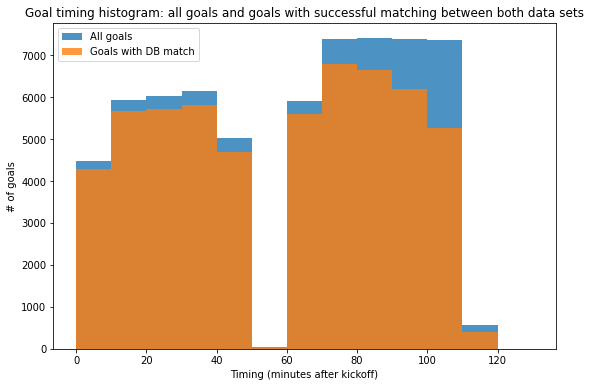

In [ ]:
import matplotlib.pyplot as plt

df = goals_df.copy()

fig, ax = plt.subplots(figsize = (9,6))

ax.hist(df['t_footy'], label='All goals', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])
ax.hist(df[df['found_goal']==1]['t_footy'], label='Goals with DB match', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])

ax.set_xlabel("Timing (minutes after kickoff)")
ax.set_ylabel("# of goals")
ax.set_title('Goal timing histogram: all goals and goals with successful matching between both data sets')
ax.legend()

plt.show()

Goal timing histogram - for the first goal (after 0x0)



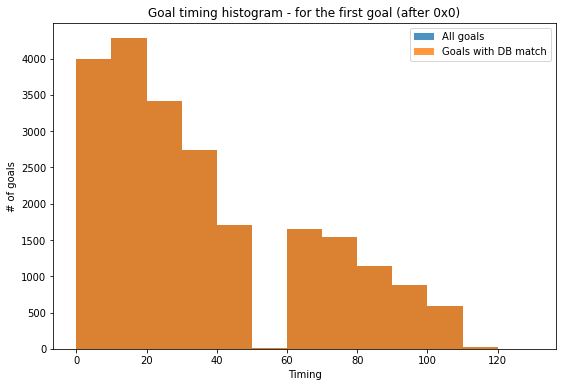

In [ ]:
import matplotlib.pyplot as plt

df = bf_goals_df[bf_goals_df['t_index']==1].copy()
df = df[(df['goalcount_home_before']==0) & (df['goalcount_away_before']==0)]

fig, ax = plt.subplots(figsize = (9,6))

ax.hist(df['t_footy'], label='All goals', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])
ax.hist(df[df['found_goal']==1]['t_footy'], label='Goals with DB match', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])

ax.set_xlabel("Timing")
ax.set_ylabel("# of goals")
ax.set_title('Goal timing histogram - for the first goal (after 0x0)')
ax.legend()

plt.show()

For the subset of first goals (after 0x0), all goals in the game stats data set were spotted in the market data set.

Goal timing histogram - for the third goal after 1x1

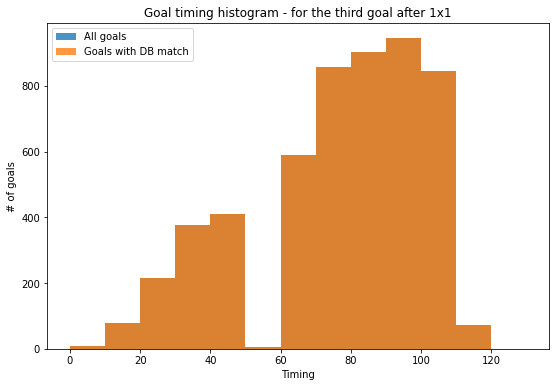

In [ ]:
import matplotlib.pyplot as plt

df = bf_goals_df[bf_goals_df['t_index']==1].copy()
df = df[(df['goalcount_home_before']==1) & (df['goalcount_away_before']==1)]

fig, ax = plt.subplots(figsize = (9,6))

ax.hist(df['t_footy'], label='All goals', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])
ax.hist(df[df['found_goal']==1]['t_footy'], label='Goals with DB match', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])

ax.set_xlabel("Timing")
ax.set_ylabel("# of goals")
ax.set_title('Goal timing histogram - for the third goal after 1x1')
ax.legend()

plt.show()

For the subset of third goals after 1x1, all goals in the game stats data set were spotted in the market data set.

## Exploring the data

We define the forecast error $e$:  

$e_{it} = y_i - p_{it}$  
<br>
where  
- $e$ is the forecast error;  
- $i$ corresponds to each goal;  
- $t$ corresponds to minutes since the identification of the goal;  
- $y$ is a Bernoulli variable corresponding to the actual outcome of the match for the scoring team ($y$ = 1 if the scoring team wins the match and $y$ = 0 otherwise);
- $p$ is the scoring team win implied risk-neutral probability.



Exploring the forecast error at the minute immediately after the goal (t=1) for goals after 0x0:

In [ ]:
df = bf_goals_df[bf_goals_df['t_index']==1].copy()
df = df[(df['goalcount_home_before']==0) & (df['goalcount_away_before']==0)]
df['e_scoringteam'].describe()

count    21969.000000
mean         0.036306
std          0.443916
min         -0.985222
25%         -0.427350
50%          0.206349
75%          0.333333
max          0.996552
Name: e_scoringteam, dtype: float64

The mean of 0.036 (if statistically significant) is compatible with general conservatism, as on average the implied probability is lower than the frequency of the actual outcome. Before the goal, implied probabilities were lower and they were updated upward, but not sufficiently.  
Commission is around 5.5-6%.  
Let us check the evolution of $e$ as time progresses: 

In [ ]:
for t in [1,2,3,4,5]:
  df = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df = df[(df['goalcount_home_before']==0) & (df['goalcount_away_before']==0)]
  print('for t = {}'.format(t) +', e_mean = ' + str(round(df['e_scoringteam'].mean(),4)) )

for t = 1, e_mean = 0.0363
for t = 2, e_mean = 0.0117
for t = 3, e_mean = 0.0083
for t = 4, e_mean = 0.0069
for t = 5, e_mean = 0.0058


The error term decreases with time, compatible with a trend following a conservative update after the event.

Exploring the forecast error at the minute immediately after the goal (t=1) for goals after 1x1:

In [ ]:
df = bf_goals_df[bf_goals_df['t_index']==1].copy()
df = df[(df['goalcount_home_before']==1) & (df['goalcount_away_before']==1)]
df['e_scoringteam'].describe()

count    5303.000000
mean        0.060336
std         0.411579
min        -0.970874
25%         0.047619
50%         0.166667
75%         0.280576
max         0.997531
Name: e_scoringteam, dtype: float64

Let us check the evolution of $e$ as time progresses: 

In [ ]:
for t in [1,2,3,4,5]:
  df = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df = df[(df['goalcount_home_before']==1) & (df['goalcount_away_before']==1)]
  print('for t = {}'.format(t) +', e_mean = ' + str(round(df['e_scoringteam'].mean(),4)) )

for t = 1, e_mean = 0.0603
for t = 2, e_mean = 0.0284
for t = 3, e_mean = 0.0211
for t = 4, e_mean = 0.0201
for t = 5, e_mean = 0.0179


The pattern is similar to what happens following goals after 0x0, but the error is higher.  
This would imply an even more conservative update following goals after 1x1 vis-à-vis goals after 0x0.  
The attention hypothesis would predict the opposite effect, i.e. a less conservative update or maybe even overreaction, as a consequence of arousal caused by the first two goals.  
Let us perform a series of logistic regressions, similar to Choi and Hui (2014), but adapted to our case. 

# Series of logistic regressions

$y_i \sim Bernoulli(\pi_{it})$  

$logit(\pi_{it}) = logit(p_{it}) + after00_i + after11_i $ where:

- $i$ corresponds to each goal;  
- $t$ corresponds to how many minutes since the identification of the goal;  
- $y$ is a Bernoulli variable corresponding to the actual outcome of the match for the scoring team ($y$ = 1 if the scoring team wins the match and $y$ = 0 otherwise);
- $p$ is the scoring team win implied risk-neutral probability. The corresponding logodds are the offset;
- $after00$ and $after11$ are binary variables indicating the goal type (therefore, no intercept).

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

for t in [1,2,3,4,5]:
  df1 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df1 = df1[(df1['goalcount_home_before']==0) & (df1['goalcount_away_before']==0)]
  df1['after1x1']=0
  df1['after0x0']=1

  df2 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df2 = df2[(df2['goalcount_home_before']==1) & (df2['goalcount_away_before']==1)]
  df2['after1x1']=1
  df2['after0x0']=0

  df = df1.append(df2)

  df['logodds_scoringteam'] = (np.where(df['scoring_team'] == 'home', 1, 0) * df['logodds_home']) + (np.where(df['scoring_team'] == 'home', 0, 1) * df['logodds_away'])
  cols = ['logodds_scoringteam','after1x1', 'after0x0', 't', 'y_scoringteam']
  data = df[cols]

  formula = 'y_scoringteam ~ after0x0 + after1x1 -1'
  model = smf.glm(formula = formula, data=data, family=sm.families.Binomial(), offset=data['logodds_scoringteam'])
  
  result = model.fit()
  print("\033[1m" + 'for time after goal = {}'.format(t) + "\033[0m")
  print(result.summary())
  print("\033[1m" + "p-Values" + "\033[0m")
  print(result.pvalues)

  # output the odds ratios and 95% CI
  conf = result.conf_int()
  conf['odds_ratio'] = result.params
  conf.columns = ['2.5%', '97.5%', 'odds_ratio']
  print("")
  print("\033[1m" + "Odds Ratio" + "\033[0m")
  print (np.exp(conf))
  print("")
  print(88*"_")
  print("")

for time after goal = 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:          y_scoringteam   No. Observations:                27272
Model:                            GLM   Df Residuals:                    27270
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15531.
Date:                Mon, 22 Feb 2021   Deviance:                       31061.
Time:                        13:45:44   Pearson chi2:                 3.28e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
after0x0       0.1917      0

The results indicate that the update in subjective probabilities following goals after 1x1 is on average indeed more conservative than the update in subjective probabilities following goals after 0x0.  
But on average goals following 1x1 happen later in the game.  

Histogram: goals after 0x0 and goals after 1x1


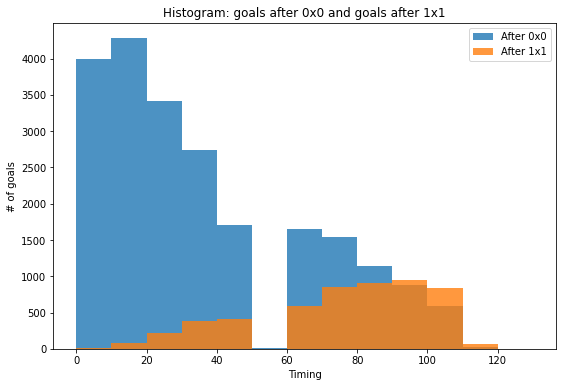

In [ ]:
import matplotlib.pyplot as plt

df = bf_goals_df[bf_goals_df['t_index']==1].copy()
df0 = df[(df['goalcount_home_before']==0) & (df['goalcount_away_before']==0)]
df1 = df[(df['goalcount_home_before']==1) & (df['goalcount_away_before']==1)]

fig, ax = plt.subplots(figsize = (9,6))

ax.hist(df0['t_footy'], label='After 0x0', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])
ax.hist(df1['t_footy'], label='After 1x1', alpha = 0.8,
        bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130])

ax.set_xlabel("Timing")
ax.set_ylabel("# of goals")
ax.set_title('Histogram: goals after 0x0 and goals after 1x1')
ax.legend()

plt.show()

We introduce the timing of the goal in the model.  
<br>
Now $logit(\pi_{it}) = logit(p_{it}) + after00_i + after11_i +\beta_ttiming_i$

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

for t in [1,2,3,4,5]:
  df1 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df1 = df1[(df1['goalcount_home_before']==0) & (df1['goalcount_away_before']==0)]
  df1['after1x1']=0
  df1['after0x0']=1

  df2 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df2 = df2[(df2['goalcount_home_before']==1) & (df2['goalcount_away_before']==1)]
  df2['after1x1']=1
  df2['after0x0']=0

  df = df1.append(df2)

  df['logodds_scoringteam'] = (np.where(df['scoring_team'] == 'home', 1, 0) * df['logodds_home']) + (np.where(df['scoring_team'] == 'home', 0, 1) * df['logodds_away'])
  df['timing'] = df['t']
  cols = ['logodds_scoringteam','after1x1', 'after0x0', 'timing', 'y_scoringteam']
  data = df[cols]

  formula = 'y_scoringteam ~ after0x0 + after1x1 + timing -1'
  model = smf.glm(formula = formula, data=data, family=sm.families.Binomial(), offset=data['logodds_scoringteam'])
  
  result = model.fit()
  print("\033[1m" + 'for time after goal = {}'.format(t) + "\033[0m")
  print(result.summary())
  print("\033[1m" + "p-Values" + "\033[0m")
  print(result.pvalues)

  # output the odds ratios and 95% CI
  conf = result.conf_int()
  conf['odds_ratio'] = result.params
  conf.columns = ['2.5%', '97.5%', 'odds_ratio']
  print("")
  print("\033[1m" + "Odds Ratio" + "\033[0m")
  print (np.exp(conf))
  print("")
  print(88*"_")
  print("")

for time after goal = 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:          y_scoringteam   No. Observations:                27272
Model:                            GLM   Df Residuals:                    27269
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15466.
Date:                Mon, 22 Feb 2021   Deviance:                       30931.
Time:                        14:05:54   Pearson chi2:                 3.28e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
after0x0      -0.0133      0

The timing of the goal is statistically significant in all cases with a decreasing coefficient.  
For t=2 and t=3, after0x0 is significant with a negative coefficient.  
It seems that the conclusion is that the timing is the reigning factor, as we do not see a specific effect of after0x0/after1x1 when controlled for the timing.  
Next, we drop after0x0/after1x1 and allow for an intercept.  
<br>Now $logit(\pi_{it}) = logit(p_{it}) + \alpha_t +\beta_ttiming_i$


In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

for t in [1,2,3,4,5]:
  df1 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df1 = df1[(df1['goalcount_home_before']==0) & (df1['goalcount_away_before']==0)]
  df1['after1x1']=0
  df1['after0x0']=1

  df2 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df2 = df2[(df2['goalcount_home_before']==1) & (df2['goalcount_away_before']==1)]
  df2['after1x1']=1
  df2['after0x0']=0

  df = df1.append(df2)

  df['logodds_scoringteam'] = (np.where(df['scoring_team'] == 'home', 1, 0) * df['logodds_home']) + (np.where(df['scoring_team'] == 'home', 0, 1) * df['logodds_away'])
  df['timing'] = df['t']
  cols = ['logodds_scoringteam','after1x1', 'after0x0', 'timing', 'y_scoringteam']
  data = df[cols]

  formula = 'y_scoringteam ~ timing '
  model = smf.glm(formula = formula, data=data, family=sm.families.Binomial(), offset=data['logodds_scoringteam'])
  
  result = model.fit()
  print("\033[1m" + 'for time after goal = {}'.format(t) + "\033[0m")
  print(result.summary())
  print("\033[1m" + "p-Values" + "\033[0m")
  print(result.pvalues)

  # output the odds ratios and 95% CI
  conf = result.conf_int()
  conf['odds_ratio'] = result.params
  conf.columns = ['2.5%', '97.5%', 'odds_ratio']
  print("")
  print("\033[1m" + "Odds Ratio" + "\033[0m")
  print (np.exp(conf))
  print("")
  print(88*"_")
  print("")

for time after goal = 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:          y_scoringteam   No. Observations:                27272
Model:                            GLM   Df Residuals:                    27270
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15466.
Date:                Mon, 22 Feb 2021   Deviance:                       30931.
Time:                        14:27:46   Pearson chi2:                 3.28e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0121      0

Using only goals after 0x0 renders:

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

for t in [1,2,3,4,5]:
  df1 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df1 = df1[(df1['goalcount_home_before']==0) & (df1['goalcount_away_before']==0)]
  df1['after1x1']=0
  df1['after0x0']=1

  df2 = bf_goals_df[bf_goals_df['t_index']==t].copy()
  df2 = df2[(df2['goalcount_home_before']==1) & (df2['goalcount_away_before']==1)]
  df2['after1x1']=1
  df2['after0x0']=0

  df = df1 #Using only goals after 0x0

  df['logodds_scoringteam'] = (np.where(df['scoring_team'] == 'home', 1, 0) * df['logodds_home']) + (np.where(df['scoring_team'] == 'home', 0, 1) * df['logodds_away'])
  df['timing'] = df['t']
  cols = ['logodds_scoringteam','after1x1', 'after0x0', 'timing', 'y_scoringteam']
  data = df[cols]

  formula = 'y_scoringteam ~ timing '
  model = smf.glm(formula = formula, data=data, family=sm.families.Binomial(), offset=data['logodds_scoringteam'])
  
  result = model.fit()
  print("\033[1m" + 'for time after goal = {}'.format(t) + "\033[0m")
  print(result.summary())
  print("\033[1m" + "p-Values" + "\033[0m")
  print(result.pvalues)

  # output the odds ratios and 95% CI
  conf = result.conf_int()
  conf['odds_ratio'] = result.params
  conf.columns = ['2.5%', '97.5%', 'odds_ratio']
  print("")
  print("\033[1m" + "Odds Ratio" + "\033[0m")
  print (np.exp(conf))
  print("")
  print(88*"_")
  print("")

for time after goal = 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:          y_scoringteam   No. Observations:                21969
Model:                            GLM   Df Residuals:                    21967
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12717.
Date:                Mon, 22 Feb 2021   Deviance:                       25435.
Time:                        15:59:19   Pearson chi2:                 2.51e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0106      0

# First conclusions/questions and next steps  

- It seems that we could/should shift the approach from "after0x0 vs. after1x1" to the "goal timing bias".  
- There is evidence for a bias related to the timing of the goals. The later the goal, the more conservative the update.  
- Which behavioral mechanism would explain this?  
 - An idea: the "priming hypothesis". Market participants are primed by pre-live odds and by in-play odds. If the match is tied as in 0x0 or 1x1, implied percentages progressively fall and the correct Bayesian update for an eventual goal progressively increases. The later the goal, the more time market participants were primed by an implied probability at a lower level. So, when the goal occurs, they update their subjective probabilities more conservatively. I will try to think of a counterexample and test it.  
 - The underlying assumption is that priming for longer periods cause stronger effects. Sounds reasonable, but is that the case?
- Which additional analyses/regressions would be useful at this point?  

**Next steps**  
- Perform some fine tuning/additional checks on the processed database.
- Explore other formulations/ types of goals?  
- Reflect on the behavioral mechanisms that would explain the "goal timing bias".

###Poisson Simulation